In [10]:
# Analysis after LDA topic modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from collections import Counter, defaultdict

In [11]:
# Set the style for plotting
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
colors = plt.cm.tab10.colors

# Create cache directory if it doesn't exist
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)

def get_cache_path(filename):
    """Get full path for a cache file"""
    return os.path.join(cache_dir, filename)

def load_from_cache(filename):
    """Load object from cache if it exists"""
    cache_path = get_cache_path(filename)
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

def save_to_cache(obj, filename):
    """Save object to cache"""
    with open(get_cache_path(filename), 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved {filename} to cache")


In [12]:
# Industry and Job Impact Analysis
def analyze_industry_job_impact(df):
    """
    Analyze the impact of AI on different industries and job categories
    
    Args:
        df: DataFrame with topic analysis results
    
    Returns:
        Dictionary of industry and job impact data
    """
    print("Analyzing industry and job impact...")
    
    # Dictionary for impact analysis
    impact_data = {
        'industries': {},
        'jobs': {}
    }
    
    # Check if we have industry and job data
    if 'detected_industries' not in df.columns or 'detected_jobs' not in df.columns:
        print("WARNING: Industry and job detection data not available. Skip this analysis.")
        return impact_data
    
    # Extract industries
    all_industries = []
    for ind_list in df['detected_industries'].dropna():
        if isinstance(ind_list, list) and ind_list:
            all_industries.extend(ind_list)
    
    # Extract jobs
    all_jobs = []
    for job_list in df['detected_jobs'].dropna():
        if isinstance(job_list, list) and job_list:
            all_jobs.extend(job_list)
    
    # Count industries and jobs
    industry_counts = Counter(all_industries)
    job_counts = Counter(all_jobs)
    
    # Get top industries and jobs
    top_industries = [ind for ind, count in industry_counts.most_common(10)]
    top_jobs = [job for job, count in job_counts.most_common(10)]
    
    # Calculate sentiment by industry if sentiment data is available
    if 'sentiment_overall' in df.columns:
        # Industry sentiment
        industry_sentiment = {}
        for industry in top_industries:
            industry_articles = df[df['detected_industries'].apply(
                lambda x: isinstance(x, list) and industry in x
            )]
            if not industry_articles.empty:
                industry_sentiment[industry] = industry_articles['sentiment_overall'].mean()
        
        # Job sentiment
        job_sentiment = {}
        for job in top_jobs:
            job_articles = df[df['detected_jobs'].apply(
                lambda x: isinstance(x, list) and job in x
            )]
            if not job_articles.empty:
                job_sentiment[job] = job_articles['sentiment_overall'].mean()
        
        # Store results
        impact_data['industries'] = {
            'counts': industry_counts,
            'sentiment': industry_sentiment
        }
        
        impact_data['jobs'] = {
            'counts': job_counts,
            'sentiment': job_sentiment
        }
    
    return impact_data

In [13]:
# Technology Adoption Analysis
def analyze_technology_adoption(df):
    """
    Analyze the adoption and mention patterns of AI technologies
    
    Args:
        df: DataFrame with topic analysis results
    
    Returns:
        Dictionary of technology adoption data
    """
    print("Analyzing technology adoption...")
    
    tech_data = {
        'technology_mentions': {},
        'technology_trends': {},
        'models': {}
    }
    
    # Check if we have technology data
    if 'ai_technologies' not in df.columns:
        print("WARNING: AI technology data not available. Skip this analysis.")
        return tech_data
    
    # Extract all technology mentions
    tech_categories = defaultdict(int)
    tech_mentions = defaultdict(list)
    model_mentions = defaultdict(int)
    
    for _, row in df.iterrows():
        techs = row.get('ai_technologies', {})
        if not techs:
            continue
        
        date = row['date']
        
        for tech_category, tech_items in techs.items():
            tech_categories[tech_category] += 1
            
            if isinstance(tech_items, list):
                for tech in tech_items:
                    tech_mentions[tech].append(date)
                    
                    # Check if this is a model name
                    if tech_category == 'specific_models':
                        model_mentions[tech] += 1
            else:
                tech_mentions[str(tech_items)].append(date)
    
    # Get top technologies by category
    tech_data['technology_mentions'] = {
        'categories': dict(tech_categories),
        'models': dict(model_mentions)
    }
    
    # Technology trend analysis by year-month
    tech_trends = {}
    for tech, dates in tech_mentions.items():
        if len(dates) < 5:  # Skip technologies with few mentions
            continue
            
        # Group by year-month
        date_counts = defaultdict(int)
        for date in dates:
            yearmonth = date.strftime('%Y-%m')
            date_counts[yearmonth] += 1
        
        # Convert to timeseries
        if date_counts:
            tech_trends[tech] = dict(date_counts)
    
    tech_data['technology_trends'] = tech_trends
    
    return tech_data


In [14]:
# Sentiment Timeline
def analyze_sentiment_timeline(df):
    """
    Analyze sentiment changes over time
    
    Args:
        df: DataFrame with topic analysis results
    
    Returns:
        Dictionary of sentiment timeline data
    """
    print("Analyzing sentiment timeline...")
    
    sentiment_data = {
        'timeline': {},
        'by_topic': {},
        'key_events': []
    }
    
    # Check if we have sentiment data
    if 'sentiment_overall' not in df.columns and 'sentiment_base' not in df.columns:
        print("WARNING: Sentiment data not available. Skip this analysis.")
        return sentiment_data
    
    # Use available sentiment column
    sentiment_col = 'sentiment_overall' if 'sentiment_overall' in df.columns else 'sentiment_base'
    
    # Timeline by month
    df['yearmonth'] = df['date'].dt.strftime('%Y-%m')
    monthly_sentiment = df.groupby('yearmonth')[sentiment_col].mean().reset_index()
    monthly_sentiment['date'] = pd.to_datetime(monthly_sentiment['yearmonth'] + '-01')
    monthly_sentiment = monthly_sentiment.sort_values('date')
    
    # Store monthly sentiment
    sentiment_data['timeline'] = {
        'dates': monthly_sentiment['date'].dt.strftime('%Y-%m').tolist(),
        'values': monthly_sentiment[sentiment_col].tolist()
    }
    
    # Sentiment by topic
    if 'topic' in df.columns:
        topic_sentiment = {}
        for topic in df['topic'].unique():
            topic_data = df[df['topic'] == topic]
            topic_monthly = topic_data.groupby('yearmonth')[sentiment_col].mean().reset_index()
            topic_monthly['date'] = pd.to_datetime(topic_monthly['yearmonth'] + '-01')
            topic_monthly = topic_monthly.sort_values('date')
            
            topic_sentiment[int(topic)] = {
                'dates': topic_monthly['date'].dt.strftime('%Y-%m').tolist(),
                'values': topic_monthly[sentiment_col].tolist()
            }
        
        sentiment_data['by_topic'] = topic_sentiment
    
    # Key AI events to annotate
    key_events = [
        {'date': '2022-11', 'event': 'ChatGPT Release', 'impact': 0.1},
        {'date': '2023-03', 'event': 'GPT-4 Release', 'impact': 0.15},
        {'date': '2023-07', 'event': 'EU AI Act', 'impact': -0.05},
        {'date': '2023-10', 'event': 'Biden AI Executive Order', 'impact': 0.0},
        {'date': '2024-03', 'event': 'GPT-4o Release', 'impact': 0.12}
    ]
    
    sentiment_data['key_events'] = key_events
    
    return sentiment_data


In [15]:
# Cross-Topic Relationship Analysis
def analyze_topic_relationships(df, topic_terms):
    """
    Analyze relationships between topics
    
    Args:
        df: DataFrame with topic analysis results
        topic_terms: List of top terms for each topic
    
    Returns:
        Dictionary of topic relationship data
    """
    print("Analyzing topic relationships...")
    
    relationship_data = {
        'correlation': {},
        'topic_labels': {}
    }
    
    if 'topic' not in df.columns:
        print("WARNING: Topic assignment data not available. Skip this analysis.")
        return relationship_data
    
    # Create topic labels
    topic_labels = {}
    for i, terms in enumerate(topic_terms):
        label = ', '.join(terms[:3])
        topic_labels[i] = f"Topic {i}: {label}"
    
    relationship_data['topic_labels'] = topic_labels
    
    # Create a topic matrix (article x topic assignment)
    topic_dummies = pd.get_dummies(df['topic'], prefix='topic')
    
    # Calculate correlation between topics based on co-occurrence in similar time periods
    df_with_dummies = pd.concat([df, topic_dummies], axis=1)
    topic_cols = topic_dummies.columns.tolist()
    
    # Group by month and calculate topic occurrence
    monthly_topics = df_with_dummies.groupby('yearmonth')[topic_cols].sum()
    
    # Calculate correlation between topics over time
    topic_correlation = monthly_topics.corr()
    
    # Convert to dictionary for easier serialization
    corr_dict = {}
    for i in range(len(topic_correlation)):
        corr_dict[int(i)] = {}
        for j in range(len(topic_correlation)):
            corr_dict[int(i)][int(j)] = float(topic_correlation.iloc[i, j])
    
    relationship_data['correlation'] = corr_dict
    
    return relationship_data


In [16]:
# Company and Organization
def analyze_organizations(df):
    """
    Analyze the companies and organizations mentioned in relation to AI
    
    Args:
        df: DataFrame with topic analysis results
    
    Returns:
        Dictionary of organization analysis data
    """
    print("Analyzing organizations...")
    
    org_data = {
        'top_organizations': {},
        'organization_sentiment': {},
        'technology_association': {}
    }
    
    # Check if we have organization data
    if 'top_organizations' not in df.columns:
        print("WARNING: Organization data not available. Skip this analysis.")
        return org_data
    
    # Extract all organization mentions
    all_orgs = []
    for org_list in df['top_organizations'].dropna():
        if isinstance(org_list, list) and org_list:
            all_orgs.extend(org_list)
    
    # Count organizations
    org_counts = Counter(all_orgs)
    
    # Get top organizations
    top_orgs = [org for org, count in org_counts.most_common(20)]
    
    # Store top organizations
    org_data['top_organizations'] = {org: count for org, count in org_counts.most_common(20)}
    
    # Calculate sentiment by organization if sentiment data is available
    if 'sentiment_overall' in df.columns:
        org_sentiment = {}
        for org in top_orgs:
            org_articles = df[df['top_organizations'].apply(
                lambda x: isinstance(x, list) and org in x
            )]
            if not org_articles.empty:
                org_sentiment[org] = float(org_articles['sentiment_overall'].mean())
        
        org_data['organization_sentiment'] = org_sentiment
    
    # Associate organizations with AI technologies if technology data is available
    if 'ai_technologies' in df.columns:
        org_tech = {}
        for org in top_orgs:
            org_articles = df[df['top_organizations'].apply(
                lambda x: isinstance(x, list) and org in x
            )]
            
            tech_mentions = defaultdict(int)
            for _, row in org_articles.iterrows():
                techs = row.get('ai_technologies', {})
                if not techs:
                    continue
                
                for tech_category in techs.keys():
                    tech_mentions[tech_category] += 1
            
            if tech_mentions:
                org_tech[org] = dict(tech_mentions)
        
        org_data['technology_association'] = org_tech
    
    return org_data

In [17]:
def create_enhanced_visualizations(df, analysis_results, topic_terms):
    """
    Create additional enhanced visualizations beyond the basic topic plots
    
    Args:
        df: DataFrame with topic analysis results
        analysis_results: Results from all analysis functions
        topic_terms: List of top terms for each topic
        
    Returns:
        Dictionary of figure objects
    """
    print("Creating enhanced visualizations...")
    
    figures = {}
    
    # 1. Industry Impact Heatmap (if industry data available)
    if analysis_results.get('industry_job_impact', {}).get('industries', {}).get('sentiment'):
        figures['industry_heatmap'] = create_industry_impact_heatmap(df)
    
    # 2. Job Impact Analysis (if job data available)
    if analysis_results.get('industry_job_impact', {}).get('jobs', {}).get('sentiment'):
        figures['job_impact'] = create_job_impact_chart(
            analysis_results['industry_job_impact']['jobs'], 
            analysis_results['industry_job_impact']['industries']
        )
    
    # 3. Technology Adoption Timeline (if technology data available)
    if analysis_results.get('technology_adoption', {}).get('technology_trends'):
        figures['technology_timeline'] = create_technology_timeline(
            analysis_results['technology_adoption']['technology_trends']
        )
    
    # 4. Sentiment Timeline with Events (if sentiment data available)
    if analysis_results.get('sentiment_timeline', {}).get('timeline'):
        figures['sentiment_timeline'] = create_sentiment_timeline_with_events(
            analysis_results['sentiment_timeline']
        )
    
    # 5. Topic Correlation Heatmap
    if analysis_results.get('topic_relationships', {}).get('correlation'):
        figures['topic_correlation'] = create_topic_correlation_heatmap(
            analysis_results['topic_relationships']['correlation'],
            analysis_results['topic_relationships']['topic_labels']
        )
    
    # 6. Organization AI Strategy Comparison
    if analysis_results.get('organization_analysis', {}).get('organization_sentiment'):
        figures['org_strategy'] = create_organization_strategy_chart(
            analysis_results['organization_analysis']
        )
    
    return figures

def create_industry_impact_heatmap(df):
    """Create a heatmap showing AI's impact on different industries over time"""
    if 'detected_industries' not in df.columns or 'sentiment_overall' not in df.columns:
        return plt.figure()
    
    # Creating one row per industry
    exploded_df = df.explode('detected_industries').dropna(subset=['detected_industries'])
    
    # Get industry counts
    industry_counts = exploded_df['detected_industries'].value_counts()
    
    # Top industries
    top_industries = industry_counts.head(10).index.tolist()
    
    # Filter for top industries
    industry_df = exploded_df[exploded_df['detected_industries'].isin(top_industries)]
    
    # Grouping by industry and year
    industry_df['year'] = industry_df['date'].dt.year
    industry_year_sentiment = industry_df.groupby(['detected_industries', 'year'])['sentiment_overall'].mean().reset_index()
    
    # Create pivot table
    pivot_df = industry_year_sentiment.pivot(index='detected_industries', columns='year', values='sentiment_overall')
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title('AI Impact Sentiment by Industry and Year')
    plt.ylabel('Industry')
    plt.xlabel('Year')
    plt.tight_layout()
    
    return plt.gcf()

def create_job_impact_chart(job_data, industry_data):
    """Create a chart showing AI's impact on different job categories"""
    if not job_data.get('sentiment'):
        return plt.figure()
    
    # Prepare data for plotting
    job_impact = []
    
    for job, sentiment in job_data['sentiment'].items():
        mention_count = job_data['counts'][job]
        impact_type = 'Enhanced' if sentiment > 0 else 'Replaced'
        
        job_impact.append({
            'job_category': job,
            'sentiment_score': sentiment,
            'mention_count': mention_count,
            'impact_type': impact_type
        })
    
    # Convert to DataFrame
    df_job_impact = pd.DataFrame(job_impact)
    
    # Sort by impact type and sentiment
    df_job_impact = df_job_impact.sort_values(['impact_type', 'sentiment_score'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot enhanced jobs
    enhanced = df_job_impact[df_job_impact['impact_type'] == 'Enhanced']
    replaced = df_job_impact[df_job_impact['impact_type'] == 'Replaced']
    
    bars_enhanced = ax.barh(
        y=enhanced['job_category'],
        width=enhanced['sentiment_score'] * enhanced['mention_count'] / 100,  # Scale by mentions
        height=0.7,
        color='green',
        alpha=0.7,
        label='Enhanced by AI'
    )
    
    bars_replaced = ax.barh(
        y=replaced['job_category'],
        width=replaced['sentiment_score'] * replaced['mention_count'] / 100,  # Scale by mentions
        height=0.7,
        color='red',
        alpha=0.7,
        label='At Risk from AI'
    )
    
    # Add labels
    ax.set_xlabel('Impact Score (Sentiment × Mention Frequency)', fontsize=12)
    ax.set_title('Jobs Enhanced vs. At Risk from AI Technologies', fontsize=16)
    ax.legend(loc='upper right')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    
    return fig

def create_technology_timeline(tech_trends):
    """Create a timeline showing the adoption/mention of AI technologies over time"""
    if not tech_trends:
        return plt.figure()
    
    # Convert dict to DataFrame for easier plotting
    data_rows = []
    for tech, yearmonth_counts in tech_trends.items():
        for yearmonth, count in yearmonth_counts.items():
            data_rows.append({
                'technology': tech,
                'yearmonth': yearmonth,
                'count': count
            })
    
    tech_df = pd.DataFrame(data_rows)
    
    # Get top technologies by total mentions
    tech_totals = tech_df.groupby('technology')['count'].sum().sort_values(ascending=False)
    top_techs = tech_totals.head(5).index.tolist()
    
    # Filter for top technologies
    tech_df = tech_df[tech_df['technology'].isin(top_techs)]
    
    # Convert yearmonth to datetime
    tech_df['date'] = pd.to_datetime(tech_df['yearmonth'] + '-01')
    tech_df = tech_df.sort_values('date')
    
    # Create plot
    plt.figure(figsize=(14, 7))
    
    for i, tech in enumerate(top_techs):
        tech_data = tech_df[tech_df['technology'] == tech]
        plt.plot(
            tech_data['date'], 
            tech_data['count'],
            marker='o',
            linestyle='-',
            linewidth=2,
            markersize=4,
            alpha=0.8,
            color=colors[i % len(colors)],
            label=tech
        )
    
    plt.title('AI Technology Adoption Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mentions', fontsize=14)
    plt.legend(title='Technology', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

def create_sentiment_timeline_with_events(sentiment_data):
    """Create timeline of sentiment with key events annotated"""
    if not sentiment_data.get('timeline', {}).get('dates'):
        return plt.figure()
    
    # Prepare data
    dates = [pd.to_datetime(date + '-01') for date in sentiment_data['timeline']['dates']]
    values = sentiment_data['timeline']['values']
    
    plt.figure(figsize=(15, 7))
    
    # Plot sentiment line
    plt.plot(dates, values, marker='o', linestyle='-', color='blue', alpha=0.7)
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add event annotations
    for event in sentiment_data['key_events']:
        event_date = pd.to_datetime(event['date'] + '-01')
        
        # Find closest date in our data
        if event_date >= min(dates) and event_date <= max(dates):
            closest_idx = np.abs(np.array(dates) - event_date).argmin()
            event_sentiment = values[closest_idx]
            
            plt.annotate(
                event['event'],
                xy=(event_date, event_sentiment),
                xytext=(event_date, event_sentiment + event['impact']),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10
            )
    
    plt.title('AI Sentiment Timeline with Key Events', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Sentiment Score (-1 to 1)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

def create_topic_correlation_heatmap(correlation_data, topic_labels):
    """Create a heatmap showing correlation between different topics"""
    if not correlation_data:
        return plt.figure()
    
    # Convert to DataFrame
    corr_matrix = []
    topics = sorted(correlation_data.keys())
    
    for i in topics:
        row = []
        for j in topics:
            row.append(correlation_data[i][j])
        corr_matrix.append(row)
    
    corr_df = pd.DataFrame(corr_matrix, index=topics, columns=topics)
    
    # Replace indices and columns with topic labels if available
    if topic_labels:
        corr_df.index = [topic_labels.get(i, f"Topic {i}") for i in corr_df.index]
        corr_df.columns = [topic_labels.get(i, f"Topic {i}") for i in corr_df.columns]
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Topic Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    
    return plt.gcf()

def create_organization_strategy_chart(org_data):
    """Create chart comparing organizations' AI strategies"""
    if not org_data.get('organization_sentiment') or not org_data.get('technology_association'):
        return plt.figure()
    
    # Prepare data
    org_strategy = []
    
    for org in org_data['organization_sentiment'].keys():
        if org in org_data['technology_association']:
            sentiment = org_data['organization_sentiment'][org]
            mentions = org_data['top_organizations'][org]
            
            # Get primary technology focus
            tech_focus = max(
                org_data['technology_association'][org].items(),
                key=lambda x: x[1]
            )[0] if org_data['technology_association'][org] else 'Unknown'
            
            org_strategy.append({
                'organization': org,
                'sentiment': sentiment,
                'mentions': mentions,
                'tech_focus': tech_focus
            })
    
    # Convert to DataFrame
    df_strategy = pd.DataFrame(org_strategy)
    
    # Only proceed if we have data
    if df_strategy.empty:
        return plt.figure()
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Get unique technology focuses for coloring
    tech_focuses = df_strategy['tech_focus'].unique()
    colors_dict = {tech: colors[i % len(colors)] for i, tech in enumerate(tech_focuses)}
    
    # Create scatter plot
    for tech in tech_focuses:
        tech_data = df_strategy[df_strategy['tech_focus'] == tech]
        plt.scatter(
            tech_data['sentiment'],
            tech_data['mentions'],
            s=tech_data['mentions'] * 3,
            alpha=0.7,
            color=colors_dict[tech],
            label=tech
        )
    
    # Label the points with organization names
    for _, row in df_strategy.iterrows():
        plt.annotate(
            row['organization'],
            xy=(row['sentiment'], row['mentions']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )
    
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Organization AI Strategy Comparison', fontsize=16)
    plt.xlabel('Sentiment (Negative to Positive)', fontsize=14)
    plt.ylabel('Mentions (Count)', fontsize=14)
    plt.legend(title='Tech Focus', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    return plt.gcf()


In [18]:
def run_post_lda_analysis(topic_data_file='data_with_topics.pkl', output_file='complete_analysis.pkl'):
    """
    Run all post-LDA analyses on the processed data
    
    Args:
        topic_data_file: Name of the file with LDA results
        output_file: Name of the file to save complete analysis results
    
    Returns:
        Dictionary of analysis results and figures
    """
    print(f"Loading topic data from {topic_data_file}...")
    
    # Load data
    df = load_from_cache(topic_data_file)
    if df is None:
        print(f"ERROR: Could not load data from {topic_data_file}")
        return None
    
    print(f"Loaded data with {len(df)} articles")
    
    # Load LDA model and related data
    lda_model_data = load_from_cache("topic_model_10.pkl")
    if lda_model_data is None:
        print("ERROR: Could not load LDA model data")
        return None
    
    _, _, _, topic_terms = lda_model_data
    
    # Run analyses
    analysis_results = {}
    
    # 1. Industry and Job Impact Analysis
    analysis_results['industry_job_impact'] = analyze_industry_job_impact(df)
    
    # 2. Technology Adoption Analysis
    analysis_results['technology_adoption'] = analyze_technology_adoption(df)
    
    # 3. Sentiment Timeline Analysis
    analysis_results['sentiment_timeline'] = analyze_sentiment_timeline(df)
    
    # 4. Cross-Topic Relationship Analysis
    analysis_results['topic_relationships'] = analyze_topic_relationships(df, topic_terms)
    
    # 5. Company and Organization Analysis
    analysis_results['organization_analysis'] = analyze_organizations(df)
    
    # 6. Create Enhanced Visualizations
    figures = create_enhanced_visualizations(df, analysis_results, topic_terms)
    
    # Combine results
    final_results = {
        'analysis': analysis_results,
        'figures': figures
    }
    
    # Save results
    save_to_cache(final_results, output_file)
    
    print(f"Analysis complete! Results saved to {output_file}")
    return final_results

Loading topic data from data_with_topics.pkl...
Loaded data with 184391 articles
Analyzing industry and job impact...
Analyzing technology adoption...
Analyzing sentiment timeline...
Analyzing topic relationships...
Analyzing organizations...
Creating enhanced visualizations...
Saved complete_analysis.pkl to cache
Analysis complete! Results saved to complete_analysis.pkl


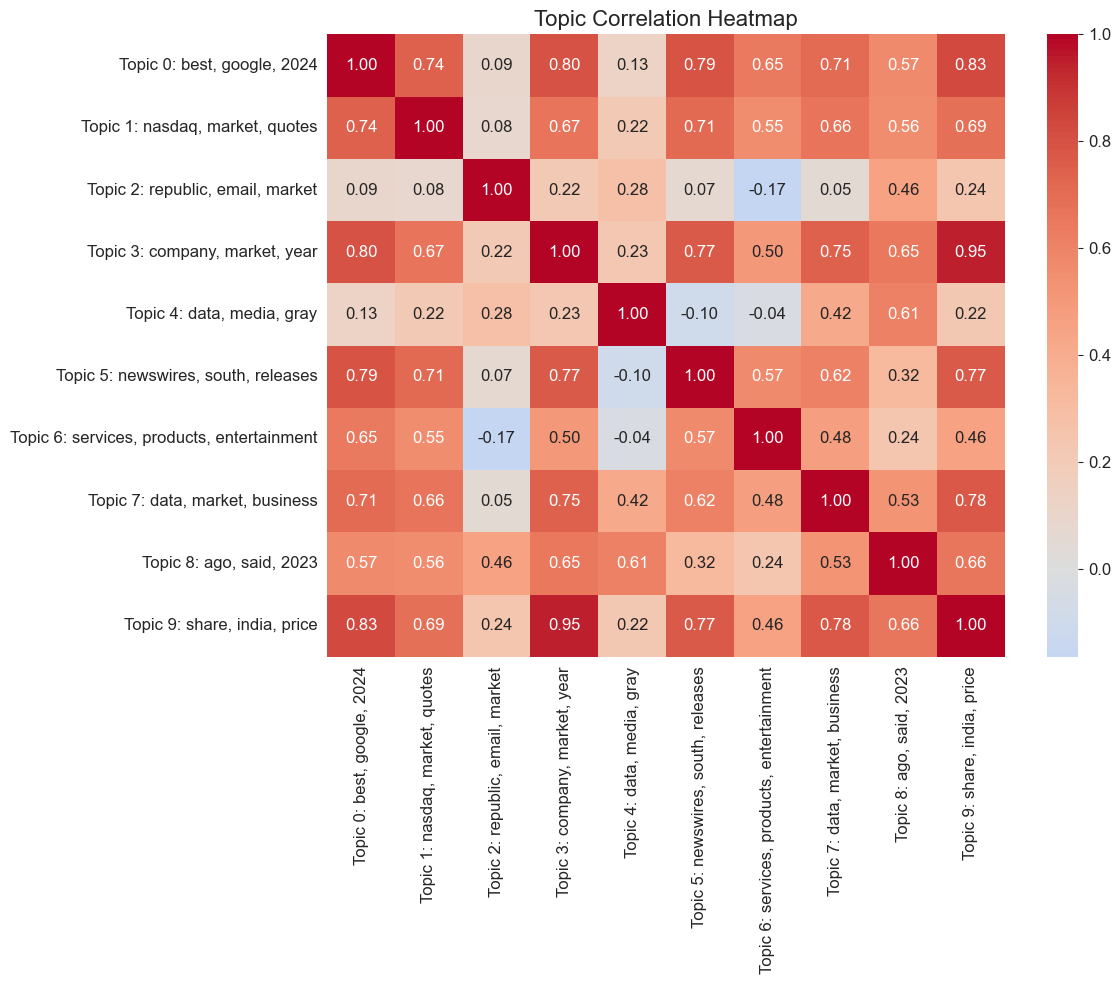

In [19]:
# Run as main program
if __name__ == "__main__":
    run_post_lda_analysis()